In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import os
import seaborn as sns
import matplotlib.pyplot as plt
import ast

In [2]:
# Ablated csv, df and unique scene labels
ablated_csv = 'tut_preds/Cnn9_64mel_tut_selected_ablated_tags.csv'
ablated_df = pd.read_csv(ablated_csv)
scene_labels = ablated_df['labels'].unique()

In [3]:
# Converting the string lists to lists
ablated_df['ablated_scene_preds'] = ablated_df['ablated_scene_preds'].apply(lambda x: ast.literal_eval(x))
ablated_df['audio_tags_org'] = ablated_df['audio_tags_org'].apply(lambda x: ast.literal_eval(x))
ablated_df['audio_tags_ablated'] = ablated_df['audio_tags_ablated'].apply(lambda x: ast.literal_eval(x))

In [4]:
# Counting the change in correct scene preds based on the indices ablated
scenewise_indices = defaultdict(dict)

for scene in scene_labels:
    scenewise_indices[scene] = {i:0 for i in range(16)}

for i, row in ablated_df.iterrows():
    scene = row['labels']
    ablated_scene_preds_ = row['ablated_scene_preds']

    for j in range(len(ablated_scene_preds_)):
        if ablated_scene_preds_[j] != scene:
            scenewise_indices[scene][j] += 1

In [5]:
# Normalizing the indices
for scene in scene_labels:
    for i in scenewise_indices[scene]:
        total = ablated_df['scene_preds'].value_counts()[scene]
        scenewise_indices[scene][i] = (scenewise_indices[scene][i]/total)

In [6]:
# Setting the threshold and determining the important indices
scenewise_imp_indices = defaultdict(dict)
count = 0
for scene in scene_labels:
    scenewise_imp_indices[scene] = []
    for i in scenewise_indices[scene]:
        #scenewise_imp_indices[scene].append(scenewise_indices[scene][i])
        if (scenewise_indices[scene][i]) >= 0.45:
            scenewise_imp_indices[scene].append(i)
            count += 1

In [7]:
# PANNs unique audio tags and counts for each scene
scene_tag_counts = defaultdict(lambda: defaultdict(int))

for i, row in ablated_df.iterrows():
    scene = row['labels']
    tags = row['audio_tags_org']
    for tag in tags:
        scene_tag_counts[scene][tag] += 1

# Same as scene_tag_counts with better readability
result = []
for scene, tags in scene_tag_counts.items():
    for tag, count in tags.items():
        result.append({'scene':scene, 'audio_tags':tag, 'count':count})

In [8]:
# Creating a nested dictionary to count indices wise missed tags
ablated_tag_counts = defaultdict(dict)

for scene in scene_labels:
    ablated_tag_counts[scene] = defaultdict(dict)
    for i in range(16):
        for event in scene_tag_counts[scene]:
            ablated_tag_counts[scene][i][event] = 0

In [9]:
# Function to determine the missed tags
def missed_tags(ablated_tags, org_tags):
    missed_ = set()
    for i in org_tags:
        if i not in ablated_tags:
            missed_.add(i)
    return list(missed_)

# Counting the missed tags for each scene and each ablated index
for i, row in ablated_df.iterrows():
    scene = row['labels']
    ablated_tags_lists = row['audio_tags_ablated']
    original_tags = row['audio_tags_org']

    for j in range(len(ablated_tags_lists)):
        missed_ = missed_tags(ablated_tags_lists[j], original_tags)
        feat_index = scenewise_imp_indices[scene][j]
        for event in missed_:
            ablated_tag_counts[scene][feat_index][event] += 1

In [30]:
# Need to define a nested dictionary to count scene wise and indices wise missed tags
ablated_tag_counts_scenewise = defaultdict(dict)
ablated_tag_counts_indiceswise = defaultdict(dict)

# All the tags in the original audio preds
all_tags = list(pd.DataFrame(scene_tag_counts).index)

# Defining the nested dictionaries
for scene in scene_labels:
    for tag in all_tags:
        ablated_tag_counts_scenewise[scene][tag] = 0
for i in range(16):
    for tag in all_tags:
        ablated_tag_counts_indiceswise[i][tag] = 0

In [31]:
# This loop is finally to get a dict/dataframe with scene wise and indices wise missed tags
for scene in ablated_tag_counts:
    for index in (ablated_tag_counts[scene]):
        for tag in (ablated_tag_counts[scene][index]):
            ablated_tag_counts_indiceswise[index][tag] += int(ablated_tag_counts[scene][index][tag])
            ablated_tag_counts_scenewise[scene][tag] += int(ablated_tag_counts[scene][index][tag])

In [32]:
# These loops are to normalise the counts along scenes and indices
for scene in scene_labels:
    total = pd.DataFrame(ablated_tag_counts_scenewise)[scene].sum()
    for tag in ablated_tag_counts_scenewise[scene]:
        ablated_tag_counts_scenewise[scene][tag] = ablated_tag_counts_scenewise[scene][tag]/total

for i in range(16):
    total = pd.DataFrame(ablated_tag_counts_indiceswise)[i].sum()
    for tag in ablated_tag_counts_indiceswise[i]:
        ablated_tag_counts_indiceswise[i][tag] = ablated_tag_counts_indiceswise[i][tag]/total

<Axes: >

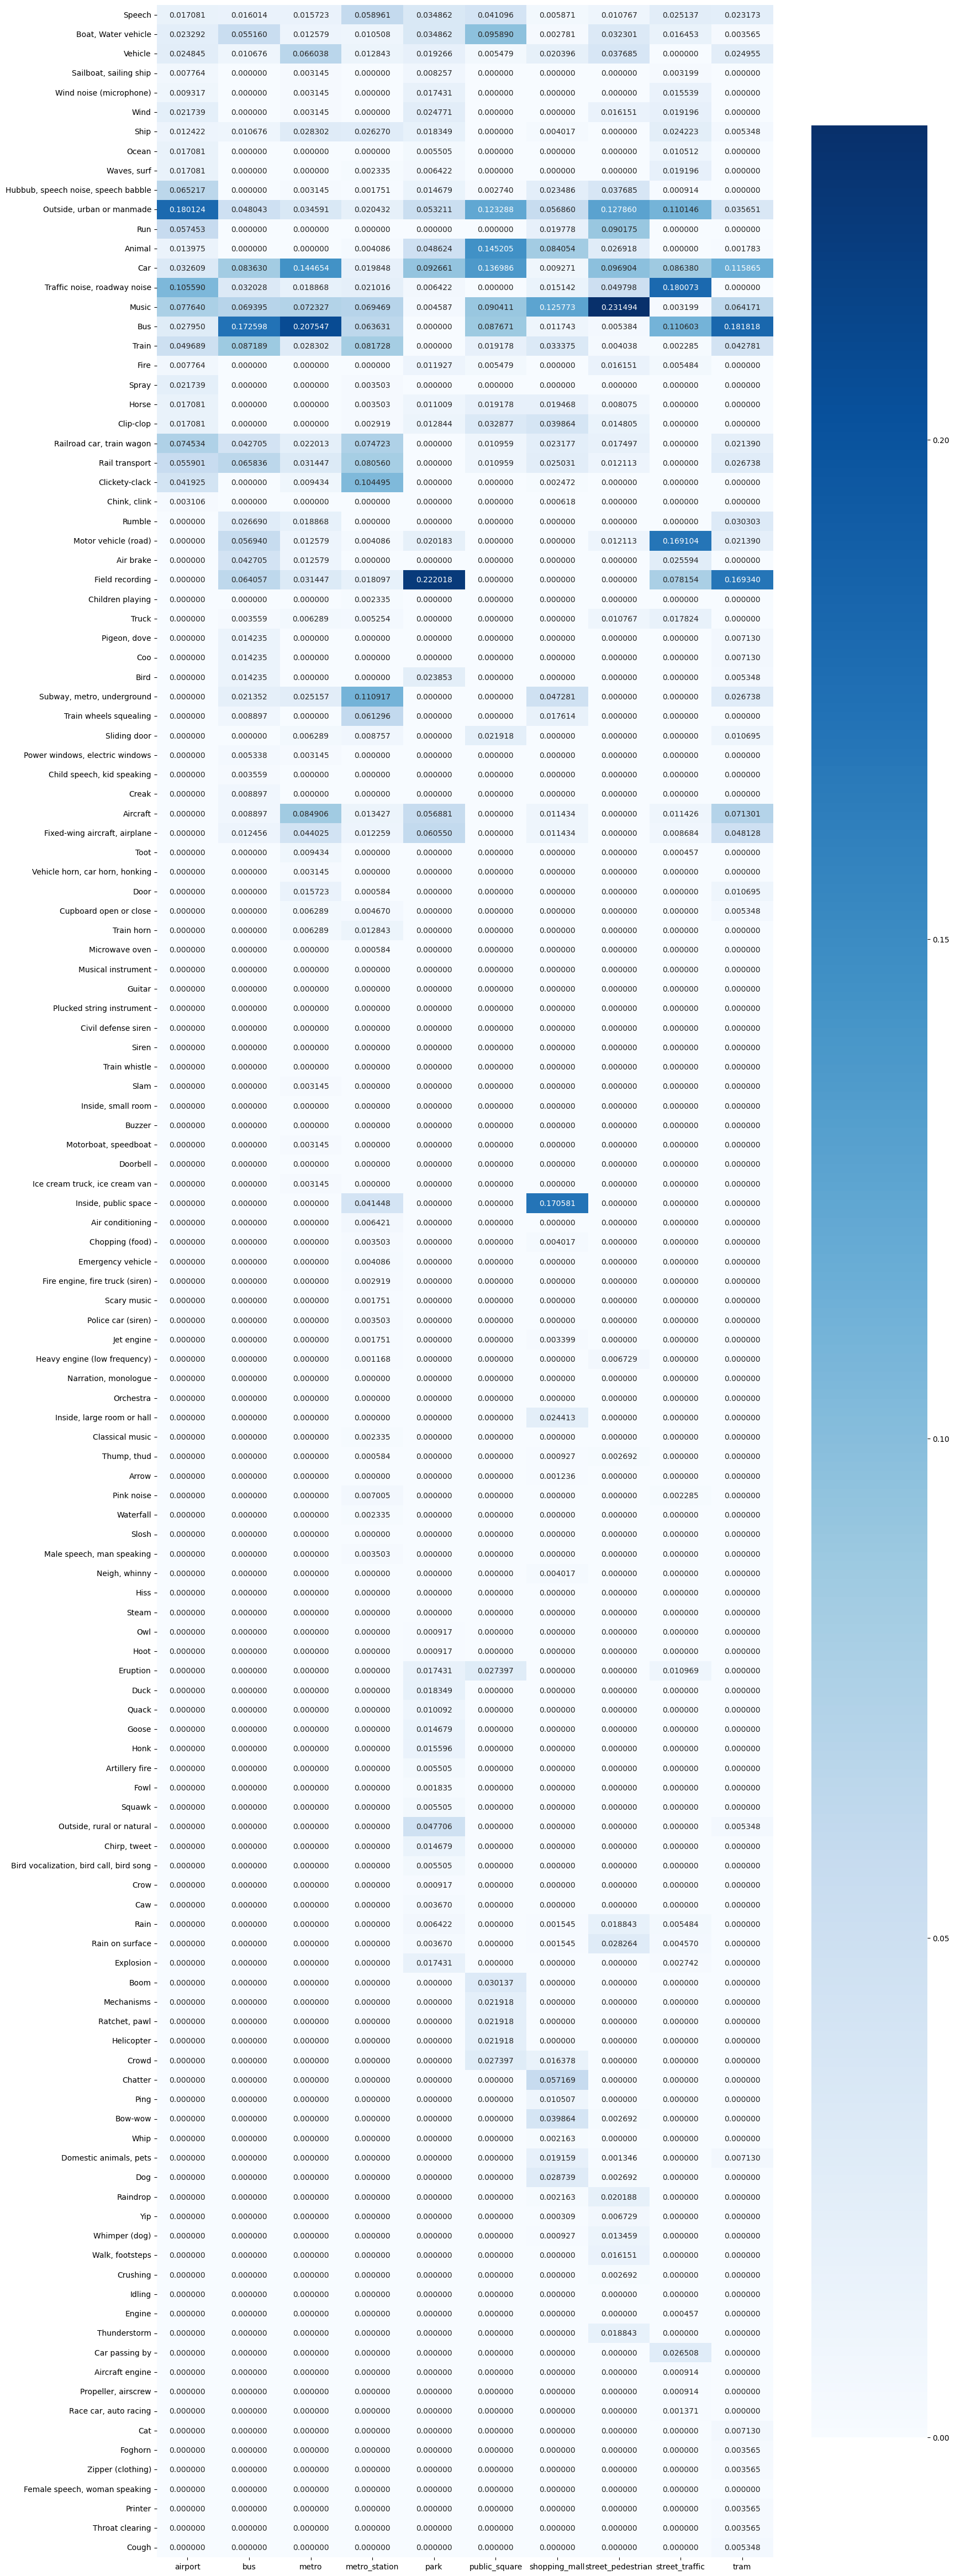

In [35]:
# Before we filter out the events, we also need to normalize the tag counts so as to get a better idea of the distribution
# Next step is going to filter out the tags a little bit
plt.figure(figsize=(18,60))
sns.heatmap(pd.DataFrame(ablated_tag_counts_scenewise), fmt='f', annot=True, cmap='Blues')

In [108]:
'''
We now have the entire dictionary of all the missed tags for each scene and each ablated index
We can now use this to:
1. look at the important tags for each scene
2. look at the tags correlation for each index
And try to see if that makes semantic sense. 
'''

'\nWe now have the entire dictionary of all the missed tags for each scene and each ablated index\nWe can now use this to:\n1. look at the important tags for each scene\n2. look at the tags correlation for each index\nAnd try to see if that makes semantic sense. \n'

<Axes: >

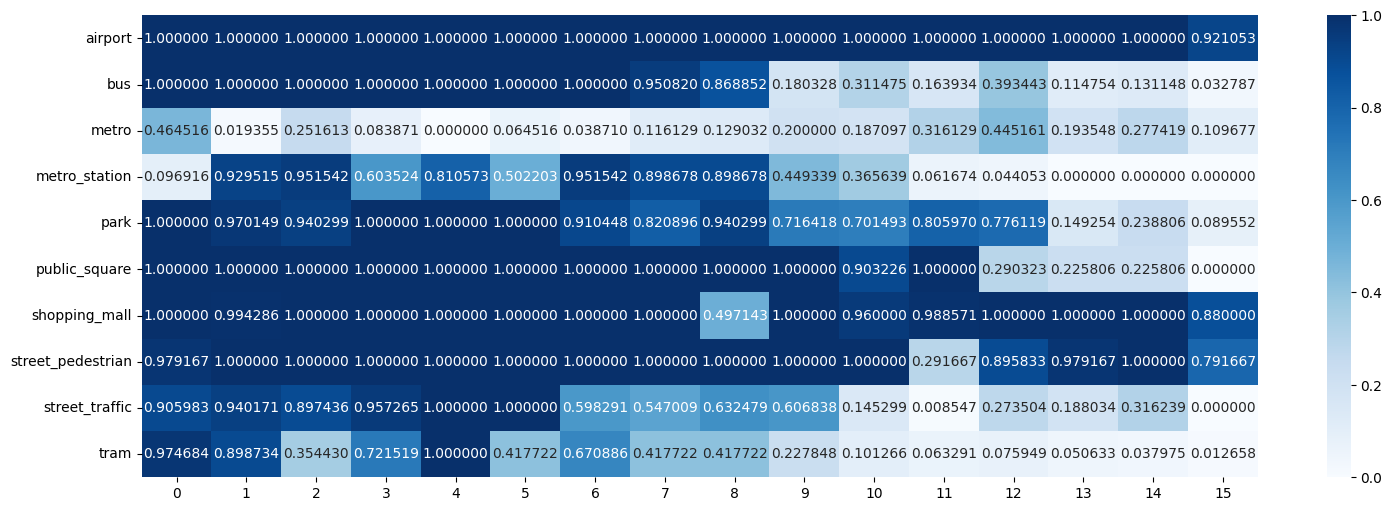

In [44]:
plt.figure(figsize=(18,6))
sns.heatmap(pd.DataFrame(scenewise_imp_indices).transpose(), fmt='f', annot=True, cmap='Blues')